In [4]:
import imp
import os
import numpy as np
import torch.nn.functional as F

In [5]:
import os.path
from os import path

if path.exists('/content/MI') == False:
  os.mkdir('/content/MI')

if path.exists('/content/MI/images') == False:
  os.mkdir('/content/MI/images')

os.chdir('/content/MI')
!pwd
!ls

/content/MI
images


In [6]:
rmdir '/content/MI/.ipynb_checkpoints'

rmdir: failed to remove '/content/MI/.ipynb_checkpoints': No such file or directory


In [7]:
DATA_DIR = '/content/MI'
print(os.listdir(DATA_DIR))

['images']


In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [9]:
image_size = 64
batch_size = 128
stats = (0.5),(0.5)  #mean and standard seviation of 0.5

In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.transforms.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
 
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def denorm(img_tensors):
    return img_tensors*stats[1]+stats[0]

In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

In [15]:
def show_batch(dl, nmax =64):
    for images,_ in dl:
        show_images(images,nmax)
        break

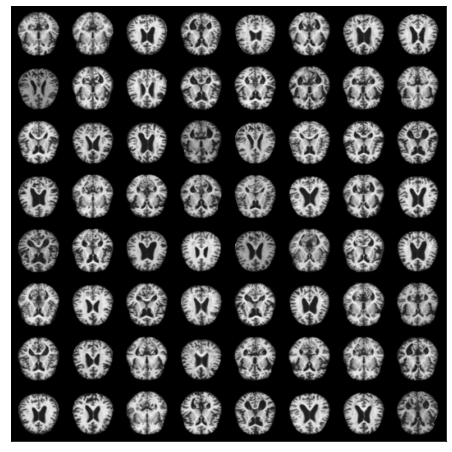

In [16]:
show_batch(train_dl)

In [17]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

In [20]:
import torch.nn as nn

In [21]:

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [22]:
discriminator = to_device(discriminator, device)

In [23]:
latent_size = 128

In [24]:

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 1, 64, 64])


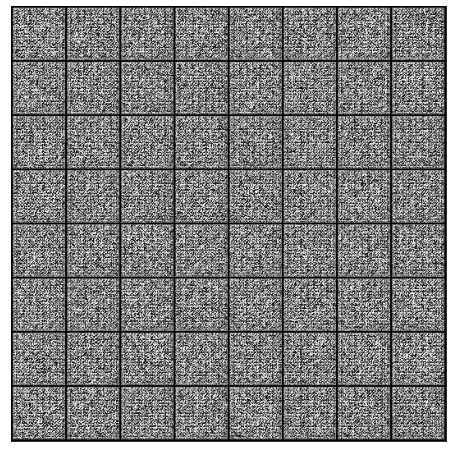

In [25]:
xb = torch.randn(batch_size,latent_size,1,1) #random instant tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

In [27]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()
  
  real_preds = discriminator(real_images)
  real_targets=torch.ones(real_images.size(0),1,device=device)
  real_loss=F.binary_cross_entropy(real_preds,real_targets)
  real_score=torch.mean(real_preds).item()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

## Train Generator

In [28]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()


In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = '/content/generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir,fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))
    

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


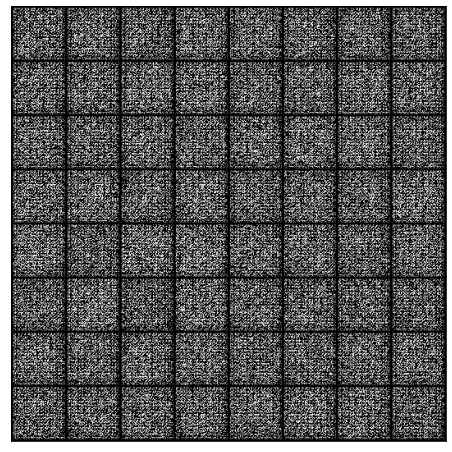

In [33]:
save_samples(0, fixed_latent)

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as r

In [35]:
def fit(epochs, lr, start_idx):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr,  betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images,_ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)
      

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}",epoch+1, epochs, loss_g, loss_d, real_score, fake_score)

    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores



In [36]:
#Training

In [37]:
lr = 0.0002
epochs = 50

In [38]:
history = fit(epochs, lr,1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 1 50 4.669251441955566 0.1508181244134903 0.9518742561340332 0.09504398703575134
Saving generated-images-0001.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 2 50 5.717121601104736 0.05874467268586159 0.9940125942230225 0.05112983286380768
Saving generated-images-0002.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 3 50 6.23759651184082 0.026334837079048157 0.9924296140670776 0.018518853932619095
Saving generated-images-0003.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 4 50 6.3618035316467285 0.012937157414853573 0.9964885115623474 0.009363275021314621
Saving generated-images-0004.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 5 50 6.452098369598389 0.01129746250808239 0.9971781969070435 0.00842594075948
Saving generated-images-0005.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 6 50 6.457675933837891 0.009626192040741444 0.9966041445732117 0.006199242547154427
Saving generated-images-0006.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 7 50 6.644623756408691 0.010667255148291588 0.9966424703598022 0.007263015024363995
Saving generated-images-0007.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 8 50 6.792502403259277 0.00872296467423439 0.9983450174331665 0.007034590467810631
Saving generated-images-0008.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 9 50 6.8836469650268555 0.01078767143189907 0.9970653057098389 0.0078108469024300575
Saving generated-images-0009.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 10 50 6.935634613037109 0.015124620869755745 0.9924330115318298 0.007483991794288158
Saving generated-images-0010.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 11 50 4.982277870178223 0.020055970177054405 0.984586238861084 0.0044388603419065475
Saving generated-images-0011.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 12 50 12.409048080444336 11.891202926635742 0.00014972359349485487 9.422076630016818e-08
Saving generated-images-0012.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 13 50 5.344113349914551 0.38061219453811646 0.9233494400978088 0.25280332565307617
Saving generated-images-0013.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 14 50 6.737456321716309 0.04270898550748825 0.9912258386611938 0.033074378967285156
Saving generated-images-0014.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 15 50 8.086543083190918 3.8444724082946777 0.02809927612543106 0.000134357251226902
Saving generated-images-0015.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 16 50 6.03755521774292 0.7967948317527771 0.9692899584770203 0.46764466166496277
Saving generated-images-0016.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 17 50 3.7674951553344727 0.1752164363861084 0.8873569965362549 0.04905997961759567
Saving generated-images-0017.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 18 50 11.800507545471191 3.4178946018218994 0.9999058246612549 0.9297465085983276
Saving generated-images-0018.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 19 50 3.6349570751190186 0.17118047177791595 0.9904357194900513 0.1462419033050537
Saving generated-images-0019.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 20 50 3.249469518661499 0.22791200876235962 0.9557433128356934 0.16204014420509338
Saving generated-images-0020.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 21 50 5.399092197418213 0.0898783877491951 0.9498641490936279 0.023678574711084366
Saving generated-images-0021.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 22 50 5.349067687988281 0.023203829303383827 0.9946078062057495 0.017537057399749756
Saving generated-images-0022.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 23 50 5.357349395751953 0.03966779634356499 0.9943654537200928 0.03321908786892891
Saving generated-images-0023.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 24 50 5.07633113861084 0.03377317264676094 0.9949466586112976 0.028071485459804535
Saving generated-images-0024.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 25 50 5.055356502532959 0.024190904572606087 0.9949352741241455 0.018854275345802307
Saving generated-images-0025.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 26 50 5.1454644203186035 0.03394017368555069 0.9956032037734985 0.02903382107615471
Saving generated-images-0026.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 27 50 5.079415321350098 0.036505162715911865 0.9918032884597778 0.027729853987693787
Saving generated-images-0027.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 28 50 5.384331703186035 0.027546603232622147 0.9837327599525452 0.010887067764997482
Saving generated-images-0028.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 29 50 5.555812835693359 0.028439823538064957 0.9806369543075562 0.00862213596701622
Saving generated-images-0029.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 30 50 5.5342488288879395 0.035480670630931854 0.9869800806045532 0.022075844928622246
Saving generated-images-0030.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 31 50 5.440706729888916 0.028068196028470993 0.9908760190010071 0.01869972050189972
Saving generated-images-0031.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 32 50 4.110857009887695 0.07703474164009094 0.9418101906776428 0.016406239941716194
Saving generated-images-0032.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 33 50 0.6121387481689453 2.359318971633911 0.10343119502067566 0.0015145059442147613
Saving generated-images-0033.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 34 50 2.4311790466308594 0.7186652421951294 0.5568649768829346 0.029748396947979927
Saving generated-images-0034.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 35 50 3.3882553577423096 0.2577030062675476 0.8697689175605774 0.10391755402088165
Saving generated-images-0035.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 36 50 3.2758328914642334 0.22303199768066406 0.9335110187530518 0.14086642861366272
Saving generated-images-0036.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 37 50 4.136186599731445 1.558451533317566 0.2375277578830719 0.006158764008432627
Saving generated-images-0037.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 38 50 5.822043418884277 1.2237021923065186 0.8869024515151978 0.6545076966285706
Saving generated-images-0038.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 39 50 3.2764501571655273 0.3108089864253998 0.9060654640197754 0.18648181855678558
Saving generated-images-0039.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 40 50 6.31021785736084 0.5212540030479431 0.9364688992500305 0.3550912141799927
Saving generated-images-0040.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 41 50 3.5443942546844482 2.294661283493042 0.1699206829071045 0.00323542021214962
Saving generated-images-0041.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 42 50 4.3592329025268555 1.0798691511154175 0.9626564383506775 0.640859842300415
Saving generated-images-0042.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 43 50 2.823554277420044 0.5084382891654968 0.7950119376182556 0.23209139704704285
Saving generated-images-0043.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 44 50 1.206974744796753 0.7530990242958069 0.5675036311149597 0.12021218240261078
Saving generated-images-0044.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 45 50 1.6060945987701416 1.0945167541503906 0.4494163990020752 0.15141350030899048
Saving generated-images-0045.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 46 50 1.9948556423187256 0.7245466709136963 0.625249981880188 0.19939064979553223
Saving generated-images-0046.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 47 50 4.01097297668457 1.2825498580932617 0.7758631110191345 0.6066359281539917
Saving generated-images-0047.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 48 50 2.23465895652771 0.5987720489501953 0.6320096254348755 0.11480578780174255
Saving generated-images-0048.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 49 50 2.6442694664001465 0.5798457860946655 0.9104174375534058 0.36185047030448914
Saving generated-images-0049.png


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f} 50 50 4.283008098602295 1.7762047052383423 0.9593599438667297 0.8001480102539062
Saving generated-images-0050.png


In [39]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [42]:
!zip -r /content/file.zip /content/generated

  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0017.png (deflated 7%)
  adding: content/generated/generated-images-0026.png (deflated 6%)
  adding: content/generated/generated-images-0016.png (deflated 6%)
  adding: content/generated/generated-images-0027.png (deflated 7%)
  adding: content/generated/generated-images-0022.png (deflated 2%)
  adding: content/generated/generated-images-0015.png (deflated 6%)
  adding: content/generated/generated-images-0014.png (deflated 5%)
  adding: content/generated/generated-images-0035.png (deflated 5%)
  adding: content/generated/generated-images-0008.png (deflated 7%)
  adding: content/generated/generated-images-0001.png (deflated 9%)
  adding: content/generated/generated-images-0043.png (deflated 4%)
  adding: content/generated/generated-images-0048.png (deflated 3%)
  adding: content/generated/generated-images-0050.png (deflated 3%)
  adding: content/generated/generated-images-0024.png (deflated 4%)
  addin

In [43]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>